In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
import scipy.optimize as optimize

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [3]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
    centroid_all.loc[centroid_all.distance == 0, 'distance'] = 0.2
    
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [7]:
target_columns = ['SE01', 'SE02', 'SE03']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'cities/{city}_{target_column}.csv',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


## Power-law and bucketed power-law models

In [5]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])

def fit_unconstrained_powerlaw(data):
    X = data[['distance', 'jobs', 'residence']].values
    y = data['flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
    return pars

def predict_unconstrained_powerlaw(data, model):
    k = model[0]
    a =  model[1]
    data['prediction'] = (data['distance']**a)*data['jobs']*data['residence']*k
    return data


def fit_bucketed_power_law(data, bins = 20):
    bins_list = data['bin'].unique()    
    bin_to_model = {}
    for b in bins_list:
        subData = data[data['bin'] == b]
        model = fit_unconstrained_powerlaw(subData)
        bin_to_model[b] = model
        
    return bin_to_model
    
def predict_bucketed_power_law(data, model):
    bins_list = data['bin'].unique()
    predictions_all = pd.DataFrame()
    for b in bins_list:
        bin_model = model[b]
        subData = data[data['bin'] == b]
        predicted = predict_unconstrained_powerlaw(subData, bin_model)
        predictions_all = pd.concat([predictions_all, predicted])
        
    return predictions_all

In [35]:
def compute_f(d, bin_model):
    for bin, model in bin_model.items():
        if d in bin:
            k = model[0]
            a =  model[1]
            return k*(d**a)

def plot_f(bin_model, subplot, color):
    x=list(range(1, 50))
    y = []
    for i in x:
      y.append(compute_f(i, bin_model)) 

    subplot.plot(x, y, color)

New York City 0.4279865340828285
Los Angeles 0.866664131252398
Chicago 0.8615080735810486
Houston 1.5435902576427325
Boston 4.561923861925414
Phoenix 1.4010772944378904
Philadelphia 1.419863649904691
San Antonio 3.0511621409203697
San Diego 2.7269462693934323
Dallas 1.5528569925226028
San Jose 2.8923272240963596
Austin 4.429003526143049
New York City 0.598762211833359
Los Angeles 0.6557860244047821
Chicago 1.2786817824602668
Houston 3.5191221824434415
Boston 4.734442586510172
Phoenix 2.7576264769279057
Philadelphia 2.489219231191686
San Antonio 6.114048432844665
San Diego 5.6908052552574375
Dallas 3.553278656704217
San Jose 3.62105238710418
Austin 9.58875321783986
New York City 1.8695595920317487
Los Angeles 1.6131529948151238
Chicago 6.401058555531978
Houston 12.587465889908065
Boston 20.79708889603637
Phoenix 5.242083734923992
Philadelphia 6.9425814506274826
San Antonio 13.963542194787678
San Diego 20.332461362211504
Dallas 10.217762644153375
San Jose 22.808915363692083
Austin 32.213

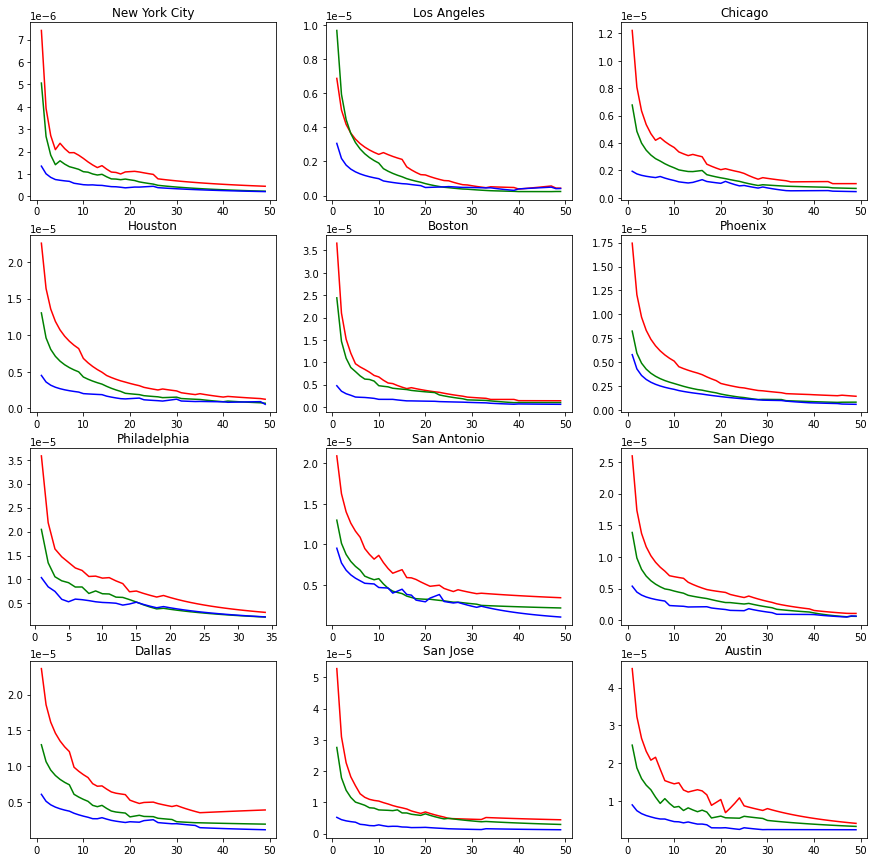

In [38]:
target_columns = ['SE01', 'SE02', 'SE03']
target_color = {'SE01': 'r', 'SE02':'g', 'SE03':'b'}
fig, ax = plt.subplots(4,3,figsize=(15,15))

for target in target_columns:
    i = 0
    for city, state, conties in cities:
        df = pd.read_csv(f'cities/{city}_{target}.csv')
        bins = 10
        df['bin'] = pd.qcut(df['distance'], q=bins)
        test_set = df.sample(frac=0.2, random_state=1)
        training_set = df.drop(test_set.index)

        model = fit_bucketed_power_law(training_set)
        prediction_results = predict_bucketed_power_law(test_set, model)
        mse = mean_squared_error(prediction_results.flow, prediction_results.prediction)

        subplot = ax[i//3,i%3]
        subplot.set_title(city)
        plot_f(model, subplot, target_color[target])

        i = i+1
        print(city, mse)